# Optimal Growth - Irreversible Investment

In [78]:
import tensorflow as tf
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import datetime
from typing import Tuple
class Vector: pass

In [97]:
# Model parameters
β = 0.99
α = 0.36
δ = 0.025
σ = 2.0
ϕ = 0.975
ρ = 0.90; 
phi = 0.975; 
Kss = ((1/β+δ-1)/(α))**(1/(α-1))
Iss = δ*Kss;
Imin = ϕ*Iss;
print(Kss, Iss)
xmin=Kss*0.9
xmax=Kss*1.1
min_FB = lambda a,b: a+b-tf.sqrt(a**2+b**2)
layers = [
    tf.keras.layers.Normalization(axis=-1, input_dim=1, mean=0, variance=1, invert=False),
    tf.keras.layers.Dense(32, activation='tanh',  bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='tanh',  bias_initializer='he_uniform'),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

def model(x:Vector)->Tuple[Vector,Vector]:
    #x = tf.concat([i[:,None] for i in [x]], axis=1)
    s = perceptron(x)
    print(x.shape)
    print(s.shape)
    c = tf.exp(s[:,1])
    h = tf.exp(s[:,2])
    print(c.shape)
    return (c,h)
λ=1
xvec = np.power(np.linspace(xmin**(1/λ),xmax**(1/λ),200,dtype='float32'),λ).reshape(-1,1)
#print(xvec)
#print(xvec.shape, model(xvec).shape)
#plt.plot(xvec, model(xvec), label = 'c(x)')

c, h = model(xvec)
print(tf.shape(c), tf.shape(h))
plt.plot(xvec,c,label='Solved c(x)',c='b')
plt.xlim([xmin,xmax])
plt.show()

37.98925353815241 0.9497313384538103
(200, 1)
(200, 2)


2023-01-26 16:59:15.160469: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at strided_slice_op.cc:111 : INVALID_ARGUMENT: slice index 2 of dimension 1 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 2 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

In [86]:
def residuals(k:Vector):
    print(tf.shape(k))
    c,h=model(k)
    print(tf.shape(c))
    kp=k**α+(1-δ)*k-c
    print(tf.shape(kp))
    cp,hp=model(kp)
    R1 = min_FB(k**α+(1-δ)*k-c, c**(-σ)-β*(α*kp**(α-1)+1-δ)*c**(-σ)-(1-δ)*hp-h)
    R2 = min_FB(h,kp-(1-δ)*k-ϕ*Iss)
    return R1,R2

def J(n):
    x = tf.random.uniform(shape=(n,),minval=xmin,maxval=xmax)
    print(tf.shape(x))
    R1,R2 = residuals(x)
    R_squared = R1*R1+R2*R2
    return tf.reduce_mean(R_squared)


residuals(xvec);
n = 500
v = J(n)
v.numpy()

tf.Tensor([200   1], shape=(2,), dtype=int32)
tf.Tensor([200], shape=(1,), dtype=int32)
tf.Tensor([200 200], shape=(2,), dtype=int32)


ValueError: Exception encountered when calling layer 'sequential_16' (type Sequential).

Input 0 of layer "dense_46" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (200, 200)

Call arguments received by layer 'sequential_16' (type Sequential):
  • inputs=tf.Tensor(shape=(200, 200), dtype=float32)
  • training=None
  • mask=None

In [57]:
θ = perceptron.trainable_variables
print(str(θ)[:1000])

[<tf.Variable 'dense_43/kernel:0' shape=(1, 32) dtype=float32, numpy=
array([[-0.26736104,  0.38324273, -0.2906385 ,  0.3835762 , -0.24267763,
        -0.09865853, -0.03071505,  0.02082253, -0.3327399 , -0.11066654,
        -0.14385411,  0.2934587 , -0.19626078, -0.24344598,  0.25222653,
         0.33113152, -0.10367158,  0.16038108,  0.2533387 ,  0.02662334,
         0.39287716,  0.05671877,  0.4213335 , -0.13042486,  0.04600564,
         0.10865384, -0.06402135,  0.2306816 , -0.36691737,  0.21153712,
         0.26355493,  0.29234672]], dtype=float32)>, <tf.Variable 'dense_43/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.06564498, -0.3641058 ,  0.41374066,  0.04095978, -0.01644865,
       -0.31585976,  0.10828063,  0.00793985,  0.14197287,  0.14352927,
        0.28266308, -0.11429015, -0.11001822,  0.19586894, -0.09731859,
       -0.06442276, -0.3651328 , -0.33371288, -0.01921183, -0.20896222,
        0.37645796, -0.1995219 ,  0.23483577, -0.15987346,  0.04285729,
       -0.2030

In [66]:
from tensorflow.keras.optimizers import Adam, SGD
variables = perceptron.trainable_variables
optimizer = SGD()
#optimizer.lr.assign(0.0000001)

In [67]:
@tf.function
def training_step():
    
    with tf.GradientTape() as tape:
        xx = J(n)
        
    grads = tape.gradient(xx,θ)
    optimizer.apply_gradients(zip(grads,θ))
    return xx

def train_me(K):
    vals=[]
    for k in tqdm(tf.range(K)):
        val=training_step()
        vals.append(val.numpy())
    return vals

In [68]:
results = train_me(5000)

  0%|                                                  | 0/5000 [00:00<?, ?it/s]

Tensor("Shape:0", shape=(1,), dtype=int32)
Tensor("Shape:0", shape=(1,), dtype=int32)


100%|██████████████████████████████████████| 5000/5000 [00:11<00:00, 438.98it/s]


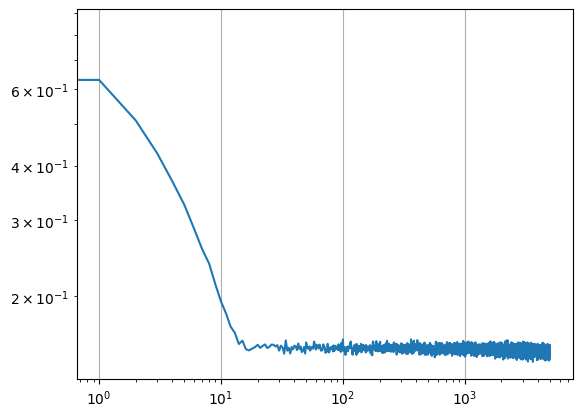

In [69]:
plt.plot(np.sqrt(results))
plt.xscale('log')
plt.yscale('log')
plt.grid()

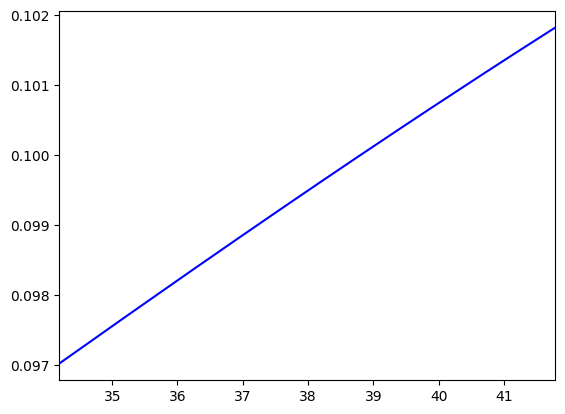

In [73]:
c, h = model(xvec)
plt.plot(xvec,c,label='Solved c(x)',c='b')
plt.xlim([xmin,xmax])
plt.show()

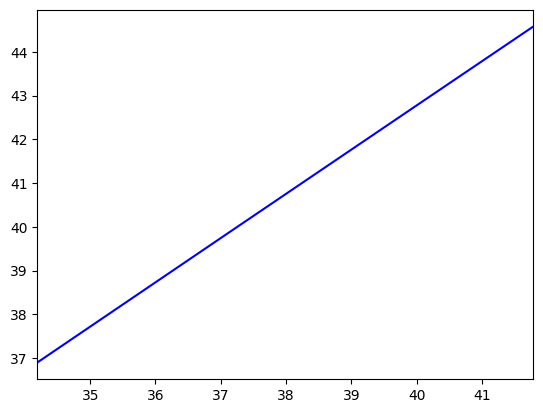

In [75]:
c,h=model(xvec)
plt.plot(xvec,xvec**α+(1-δ)*xvec,label='c(x)',c='b')
plt.xlim([xmin,xmax])
plt.show()

In [76]:
c,h=model(xvec)
print(tf.shape(xvec))
print(tf.shape(c))
kp=xvec**α+(1-δ)*xvec-c
cp,hp=model(kp)
invst = kp-(1-δ)*xvec-ϕ*Iss
plt.plot(xvec,invst,label='Solved c(x)',c='b')
plt.xlim([xmin,xmax])
plt.show()

tf.Tensor([200   1], shape=(2,), dtype=int32)
tf.Tensor([200], shape=(1,), dtype=int32)


ValueError: Exception encountered when calling layer 'sequential_15' (type Sequential).

Input 0 of layer "dense_43" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (200, 200)

Call arguments received by layer 'sequential_15' (type Sequential):
  • inputs=tf.Tensor(shape=(200, 200), dtype=float32)
  • training=None
  • mask=None

In [147]:
tf.shape(xvec)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([200,   1], dtype=int32)>

In [41]:
c

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([0.08020786, 0.08033138, 0.08045516, 0.08057906, 0.08070326,
       0.08082759, 0.08095222, 0.0810769 , 0.08120181, 0.08132678,
       0.08145225, 0.08157762, 0.08170342, 0.08182924, 0.08195527,
       0.08208152, 0.08220809, 0.08233467, 0.08246148, 0.08258862,
       0.08271578, 0.08284324, 0.08297087, 0.08309868, 0.08322675,
       0.08335499, 0.08348338, 0.08361203, 0.08374087, 0.08386979,
       0.08399904, 0.08412843, 0.08425809, 0.08438786, 0.08451791,
       0.08464808, 0.08477847, 0.08490911, 0.08503991, 0.08517101,
       0.08530208, 0.0854336 , 0.08556525, 0.08569705, 0.08582912,
       0.08596125, 0.08609373, 0.08622646, 0.08635911, 0.08649231,
       0.08662548, 0.08675908, 0.08689267, 0.08702652, 0.08716066,
       0.08729492, 0.08742933, 0.0875641 , 0.08769898, 0.08783409,
       0.08796954, 0.08810486, 0.08824073, 0.08837663, 0.08851277,
       0.08864935, 0.08878582, 0.08892246, 0.08905955, 0.08919671,
       0.08933

In [148]:
kp

<tf.Tensor: shape=(200, 200), dtype=float32, numpy=
array([[36.77087 , 36.7711  , 36.771328, ..., 36.809834, 36.81    ,
        36.81017 ],
       [36.809532, 36.80976 , 36.80999 , ..., 36.848495, 36.848663,
        36.84883 ],
       [36.84819 , 36.84842 , 36.848648, ..., 36.887154, 36.88732 ,
        36.88749 ],
       ...,
       [44.368965, 44.369194, 44.369423, ..., 44.40793 , 44.408096,
        44.408264],
       [44.40745 , 44.40768 , 44.40791 , ..., 44.446415, 44.446583,
        44.44675 ],
       [44.445934, 44.446163, 44.446392, ..., 44.484898, 44.485065,
        44.485233]], dtype=float32)>